In [1]:
import pandas as pd
import numpy as np
from sksurv.nonparametric import kaplan_meier_estimator as kmf
import matplotlib.pyplot as plt
from lifelines.statistics import logrank_test
import matplotlib.patches as mpatches

In [5]:
selected_cell = 'Myeloid'

In [6]:
estimation = pd.read_csv('TCGA-LIHC.Immune.csv',index_col=0)
estimation.head()

,CD8+ Cells,Tregs,Non-immune cluster,Nk Cells,CD4+ Cells,B Cells,Myeloid,Mast Cells,P-value,Correlation,RMSE
Mixture,,,,,,,,,,,
TCGA-FV-A495-01,0.061526,0.036791,0.688189,0.098637,0.058827,0.009298,0.044200,0.002532,0,0.886827,0.467952
TCGA-G3-A3CH-11,0.098691,0.000000,0.738276,0.006164,0.104097,0.000367,0.049163,0.003243,0,0.919957,0.400423
TCGA-CC-A3MB-01,0.139905,0.032341,0.480762,0.118661,0.094536,0.044451,0.085290,0.004055,0,0.842832,0.582837
TCGA-BC-A3KF-01,0.114993,0.041077,0.596361,0.083589,0.062153,0.032894,0.067308,0.001626,0,0.791911,0.613901
TCGA-DD-A4NV-01,0.098896,0.002426,0.660500,0.058329,0.102381,0.027923,0.048503,0.001041,0,0.849245,0.532237


In [7]:
sample_list = [sample for sample in estimation.index.values if '-01' in sample]
estimation = estimation.reindex(sample_list)

In [8]:
survival_data = pd.read_csv('survival_LIHC_survival.txt',index_col=0,delimiter='\t')
sample_list = [sample for sample in survival_data.index.values if '-01' in sample]
survival_data = survival_data.reindex(sample_list)
survival_data.head()

,_PATIENT,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction
sample,,,,,,,,,,
TCGA-2V-A95S-01,TCGA-2V-A95S,0,NaN,0.0,NaN,0.0,NaN,0,NaN,NaN
TCGA-2Y-A9GS-01,TCGA-2Y-A9GS,1,724.0,1.0,724.0,1.0,102.0,1,102.0,NaN
TCGA-2Y-A9GT-01,TCGA-2Y-A9GT,1,1624.0,1.0,1624.0,1.0,1083.0,1,1083.0,NaN
TCGA-2Y-A9GU-01,TCGA-2Y-A9GU,0,1939.0,0.0,1939.0,0.0,1939.0,0,1939.0,NaN
TCGA-2Y-A9GV-01,TCGA-2Y-A9GV,1,2532.0,1.0,2532.0,0.0,2532.0,1,1745.0,NaN


In [9]:
dfs_data = survival_data.filter(['DFI.time', 'DFI'])
dfs_data = dfs_data.dropna(axis=0,how='any')
binary = {1:True,0:False}
dfs_data['DFS_E'] = [binary[event] for event in dfs_data['DFI']]
dfs_data['DFS_T'] = [time/30 for time in dfs_data['DFI.time']]
dfs_data.head()

,DFI.time,DFI,DFS_E,DFS_T
sample,,,,
TCGA-2Y-A9GS-01,102.0,1.0,True,3.400000
TCGA-2Y-A9GT-01,1083.0,1.0,True,36.100000
TCGA-2Y-A9GU-01,1939.0,0.0,False,64.633333
TCGA-2Y-A9GV-01,2532.0,0.0,False,84.400000
TCGA-2Y-A9GW-01,1229.0,1.0,True,40.966667


In [10]:
survival_test = estimation.merge(dfs_data,left_index=True,right_index=True,how='inner')
survival_test.head()

,CD8+ Cells,Tregs,Non-immune cluster,Nk Cells,CD4+ Cells,B Cells,Myeloid,Mast Cells,P-value,Correlation,RMSE,DFI.time,DFI,DFS_E,DFS_T
TCGA-FV-A495-01,0.061526,0.036791,0.688189,0.098637,0.058827,0.009298,0.044200,0.002532,0,0.886827,0.467952,1.0,0.0,False,0.033333
TCGA-CC-A3MB-01,0.139905,0.032341,0.480762,0.118661,0.094536,0.044451,0.085290,0.004055,0,0.842832,0.582837,315.0,0.0,False,10.500000
TCGA-BC-A3KF-01,0.114993,0.041077,0.596361,0.083589,0.062153,0.032894,0.067308,0.001626,0,0.791911,0.613901,8.0,0.0,False,0.266667
TCGA-DD-A4NV-01,0.098896,0.002426,0.660500,0.058329,0.102381,0.027923,0.048503,0.001041,0,0.849245,0.532237,2398.0,0.0,False,79.933333
TCGA-BD-A3EP-01,0.112517,0.009514,0.552465,0.099583,0.098980,0.030022,0.094342,0.002577,0,0.731948,0.683071,409.0,0.0,False,13.633333


In [11]:
survival_reorder = survival_test.sort_values(selected_cell,axis=0,ascending=False)
survival_reorder.head()

,CD8+ Cells,Tregs,Non-immune cluster,Nk Cells,CD4+ Cells,B Cells,Myeloid,Mast Cells,P-value,Correlation,RMSE,DFI.time,DFI,DFS_E,DFS_T
TCGA-CC-A9FV-01,0.053895,0.109446,0.000000,0.268829,0.110509,0.031909,0.420144,0.005268,0,0.282407,0.960751,0.0,0.0,False,0.000000
TCGA-CC-A3M9-01,0.056724,0.136140,0.000000,0.394045,0.000000,0.038717,0.373706,0.000668,0,0.367413,0.940262,219.0,1.0,True,7.300000
TCGA-CC-A7IJ-01,0.131127,0.120493,0.000000,0.269826,0.062206,0.061190,0.355031,0.000127,0,0.303670,0.957026,382.0,0.0,False,12.733333
TCGA-YA-A8S7-01,0.105216,0.059048,0.246450,0.162876,0.065561,0.037938,0.322088,0.000823,0,0.621570,0.812475,398.0,1.0,True,13.266667
TCGA-CC-A5UD-01,0.080730,0.109296,0.107063,0.252954,0.113800,0.049313,0.286844,0.000000,0,0.659271,0.852378,182.0,1.0,True,6.066667


In [12]:
running_length = len(survival_reorder)

logrank_tests = []
cut_points = []

for i in range(running_length):
    cut_point = int(i+1)
    E = list(survival_reorder['DFS_E'])
    mid_point = int(len(E)/2)
    E_high = E[:cut_point]
    E_low = E[cut_point:]
    S = list(survival_reorder['DFS_T'])
    S_high = S[:cut_point]
    S_low = S[cut_point:]
    results = logrank_test(S_high,S_low,E_high,E_low)
    p = results.p_value
    cut_points.append(cut_point)
    logrank_tests.append(p)

optimization = pd.DataFrame(logrank_tests,index=cut_points,columns=['Log Rank Test'])

In [13]:
optimization = optimization.dropna()
optimization = optimization.sort_values('Log Rank Test')
optimization = int(optimization.iloc[0].name)
optimization

80

In [14]:
dfs_cut_level = survival_reorder[selected_cell][optimization]
dfs_cut_level

0.12075269603092

In [15]:
E = list(survival_reorder['DFS_E'])
cut_point = optimization
E_high = E[:cut_point]
E_low = E[cut_point:]
S = list(survival_reorder['DFS_T'])
S_high = S[:cut_point]
S_low = S[cut_point:]
results = logrank_test(S_high,S_low,E_high,E_low)
p = results.p_value
p = round(p,5)
p

0.00378

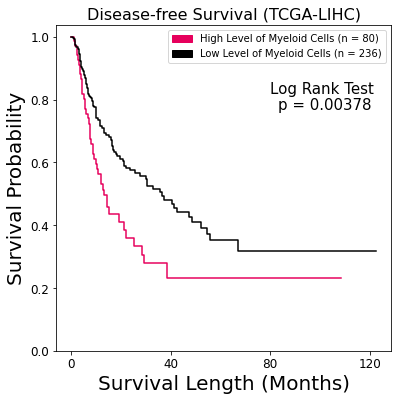

In [16]:
plt.figure(figsize=(6,6))
t,s = kmf(E_high, S_high)
plt.step(t,s,c='#e6005c')
t,s = kmf(E_low, S_low)
plt.step(t,s,c='k')
plt.xticks(np.arange(0,121,40),fontsize=12)
plt.yticks(np.arange(0,1.1,0.2),fontsize=12)
plt.xlabel('Survival Length (Months)', fontsize=20)
plt.ylabel('Survival Probability',fontsize=20)
high_patch = mpatches.Patch(color='#e6005c',label='High Level of Myeloid Cells (n = %s)'%len(E_high))
low_patch = mpatches.Patch(color='k',label='Low Level of Myeloid Cells (n = %s)'%len(E_low))
plt.text(80,0.82, 'Log Rank Test',fontsize=15)
plt.text(83,0.77, 'p = %s'%p,fontsize=15)
plt.legend(handles=[high_patch,low_patch],fontsize=10)
plt.title('Disease-free Survival (TCGA-LIHC)',fontsize=16)
plt.savefig('TCGA-LIHC.%s.DFS.pdf'%selected_cell,format='pdf')

In [17]:
os_data = survival_data.filter(['OS.time', 'OS'])
os_data = os_data.dropna(axis=0,how='any')
binary = {1:True,0:False}
os_data['OS_E'] = [binary[event] for event in os_data['OS']]
os_data['OS_T'] = [time/30 for time in os_data['OS.time']]
os_data.head()

,OS.time,OS,OS_E,OS_T
sample,,,,
TCGA-2Y-A9GS-01,724.0,1,True,24.133333
TCGA-2Y-A9GT-01,1624.0,1,True,54.133333
TCGA-2Y-A9GU-01,1939.0,0,False,64.633333
TCGA-2Y-A9GV-01,2532.0,1,True,84.400000
TCGA-2Y-A9GW-01,1271.0,1,True,42.366667


In [18]:
survival_test = estimation.merge(os_data,left_index=True,right_index=True,how='inner')
survival_test.head()

,CD8+ Cells,Tregs,Non-immune cluster,Nk Cells,CD4+ Cells,B Cells,Myeloid,Mast Cells,P-value,Correlation,RMSE,OS.time,OS,OS_E,OS_T
TCGA-FV-A495-01,0.061526,0.036791,0.688189,0.098637,0.058827,0.009298,0.044200,0.002532,0,0.886827,0.467952,1.0,0,False,0.033333
TCGA-CC-A3MB-01,0.139905,0.032341,0.480762,0.118661,0.094536,0.044451,0.085290,0.004055,0,0.842832,0.582837,315.0,1,True,10.500000
TCGA-BC-A3KF-01,0.114993,0.041077,0.596361,0.083589,0.062153,0.032894,0.067308,0.001626,0,0.791911,0.613901,8.0,0,False,0.266667
TCGA-DD-A4NV-01,0.098896,0.002426,0.660500,0.058329,0.102381,0.027923,0.048503,0.001041,0,0.849245,0.532237,2398.0,0,False,79.933333
TCGA-CC-A1HT-01,0.049722,0.125314,0.124946,0.306282,0.066158,0.041490,0.285777,0.000310,0,0.588385,0.868008,101.0,1,True,3.366667


In [19]:
survival_reorder = survival_test.sort_values(selected_cell,axis=0,ascending=False)
survival_reorder

,CD8+ Cells,Tregs,Non-immune cluster,Nk Cells,CD4+ Cells,B Cells,Myeloid,Mast Cells,P-value,Correlation,RMSE,OS.time,OS,OS_E,OS_T
TCGA-CC-A9FV-01,0.053895,0.109446,0.000000,0.268829,0.110509,0.031909,0.420144,0.005268,0,0.282407,0.960751,0.0,0,False,0.000000
TCGA-CC-A3M9-01,0.056724,0.136140,0.000000,0.394045,0.000000,0.038717,0.373706,0.000668,0,0.367413,0.940262,300.0,1,True,10.000000
TCGA-CC-A7IJ-01,0.131127,0.120493,0.000000,0.269826,0.062206,0.061190,0.355031,0.000127,0,0.303670,0.957026,382.0,0,False,12.733333
TCGA-YA-A8S7-01,0.105216,0.059048,0.246450,0.162876,0.065561,0.037938,0.322088,0.000823,0,0.621570,0.812475,412.0,1,True,13.733333
TCGA-CC-A5UD-01,0.080730,0.109296,0.107063,0.252954,0.113800,0.049313,0.286844,0.000000,0,0.659271,0.852378,304.0,1,True,10.133333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-DD-A115-01,0.079211,0.057381,0.643262,0.109459,0.070141,0.014666,0.023214,0.002667,0,0.820856,0.574257,2542.0,1,True,84.733333
TCGA-G3-AAUZ-01,0.073045,0.037281,0.767209,0.036592,0.055259,0.004872,0.022982,0.002759,0,0.909596,0.427372,480.0,0,False,16.000000
TCGA-2Y-A9H4-01,0.078513,0.074751,0.703856,0.080957,0.038911,0.000343,0.020207,0.002462,0,0.879457,0.481403,1452.0,0,False,48.400000
TCGA-ES-A2HS-01,0.059250,0.005017,0.777708,0.033812,0.080452,0.031376,0.009152,0.003233,0,0.886410,0.479375,688.0,1,True,22.933333


In [20]:
running_length = len(survival_reorder)

logrank_tests = []
cut_points = []

for i in range(running_length):
    cut_point = int(i+1)
    E = list(survival_reorder['OS_E'])
    mid_point = int(len(E)/2)
    E_high = E[:cut_point]
    E_low = E[cut_point:]
    S = list(survival_reorder['OS_T'])
    S_high = S[:cut_point]
    S_low = S[cut_point:]
    results = logrank_test(S_high,S_low,E_high,E_low)
    p = results.p_value
    cut_points.append(cut_point)
    logrank_tests.append(p)

optimization = pd.DataFrame(logrank_tests,index=cut_points,columns=['Log Rank Test'])

In [21]:
optimization = optimization.dropna()
optimization = optimization.sort_values('Log Rank Test')
optimization = int(optimization.iloc[0].name)
#optimization = int(len(E)/2)

In [22]:
os_cut_level = survival_reorder[selected_cell][optimization]
os_cut_level

0.270738141253482

In [23]:
E = list(survival_reorder['OS_E'])
cut_point = optimization
E_high = E[:cut_point]
E_low = E[cut_point:]
S = list(survival_reorder['OS_T'])
S_high = S[:cut_point]
S_low = S[cut_point:]
results = logrank_test(S_high,S_low,E_high,E_low)
p = results.p_value
p = round(p,5)
p

0.00027

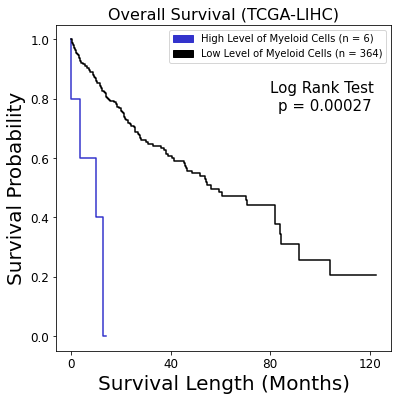

In [24]:
plt.figure(figsize=(6,6))
t,s = kmf(E_high, S_high)
plt.step(t,s,c='#3333cc')
t,s = kmf(E_low, S_low)
plt.step(t,s,c='k')
plt.xticks(np.arange(0,121,40),fontsize=12)
plt.yticks(np.arange(0,1.1,0.2),fontsize=12)
plt.xlabel('Survival Length (Months)', fontsize=20)
plt.ylabel('Survival Probability',fontsize=20)
high_patch = mpatches.Patch(color='#3333cc',label='High Level of Myeloid Cells (n = %s)'%len(E_high))
low_patch = mpatches.Patch(color='k',label='Low Level of Myeloid Cells (n = %s)'%len(E_low))
plt.text(80,0.82, 'Log Rank Test',fontsize=15)
plt.text(83,0.76, 'p = %s'%p,fontsize=15)
plt.legend(handles=[high_patch,low_patch],fontsize=10)
plt.title('Overall Survival (TCGA-LIHC)',fontsize=16)
plt.savefig('TCGA-LIHC.%s.OS.pdf'%selected_cell,format='pdf')

In [25]:
estimation = estimation.sort_values(selected_cell,ascending=False)
x = []
y = []
for key,value in enumerate(estimation[selected_cell]):
    x.append(key)
    y.append(value)

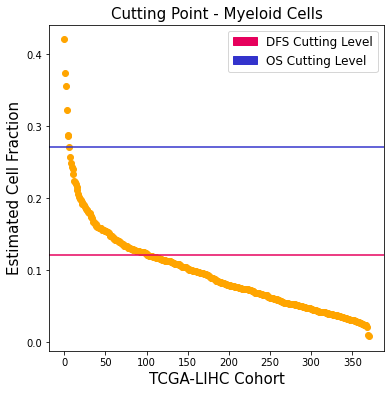

In [26]:
plt.figure(figsize=(6,6))
plt.scatter(x,y,color='orange')
plt.axhline(y=os_cut_level, xmin=0, xmax=100,color='#3333cc')
plt.axhline(y=dfs_cut_level, xmin=0, xmax=100,color='#e6005c')
plt.ylabel('Estimated Cell Fraction',fontsize=15)
plt.xlabel('TCGA-LIHC Cohort',fontsize=15)
plt.title('Cutting Point - Myeloid Cells',fontsize=15)
dfs_patch = mpatches.Patch(color='#e6005c',label='DFS Cutting Level')
os_patch = mpatches.Patch(color='#3333cc',label='OS Cutting Level')
plt.legend(handles=[dfs_patch,os_patch],fontsize=12)
#plt.yscale("log")
plt.savefig('Cutting_Point.%s'%selected_cell,format='pdf')